---
## **1. Tensorflow** 
### 1.1 Introduction & Data Processing
This notebook re-implements this [paper](https://arxiv.org/pdf/1409.4842.pdf). The image below shows the idea of **Inception block**. 

![](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-22_at_3.22.39_PM.png)



*   Framework: Tensorflow and Pytorch
*   Dataset: FashionMNIST

In [1]:
"""Import necessary libraries"""
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dense, Dropout, Input, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
"""Load data"""
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_val, y_val = X_train[:5000], y_train[:5000]
X_train, y_train = X_train[5000:], y_train[5000:]

4422102/4422102 [==============================] - 0s 0us/step


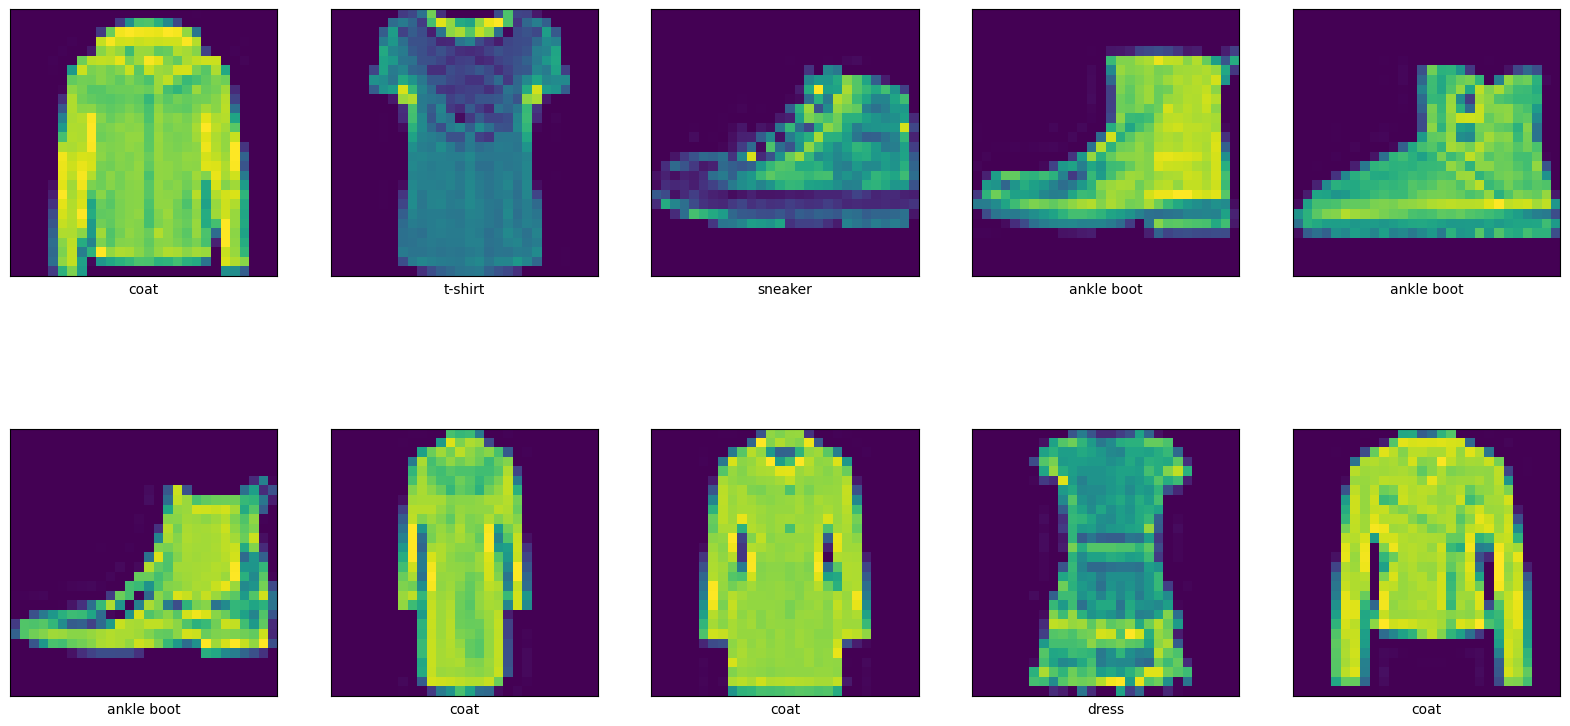

In [3]:
"""Visualize the data"""
labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.xlabel(labels[y_train[i]])
plt.show()

In [4]:
"""Parameters of model"""
num_classes, batch_size, epochs  = 100, 128, 5
X_train = (np.expand_dims(X_train, axis=-1))
X_val = (np.expand_dims(X_val, axis=-1))
X_test = (np.expand_dims(X_test, axis=-1))
train_per_epoch = X_train.shape[0]//batch_size
validation_steps = X_val.shape[0]//batch_size
test_steps = X_test.shape[0]//batch_size
print("Train per epoch: ", train_per_epoch)
print(X_train.shape)

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

Train per epoch:  429
(55000, 28, 28, 1)


In [5]:
"""Callbacks during train"""
my_callbacks = [EarlyStopping(patience=2, monitor="val_loss",),               
                ModelCheckpoint(filepath='/kaggle/working/googlenet.{epoch:02d}-{loss:.2f}.h5', monitor='val_loss', save_best_only=True),]

### 1.2 Architecture

In [6]:
"""Inception module """
def Inception(X, p1, p2, p3, p4):
    # Path 1 is a  1x1 convolutional layer
    p1_1 = Conv2D(p1, kernel_size=(1,1), activation='relu')(X)
    # Path 2 is a 1x1 convolutional layer followed by a 3x3 convolutional layer
    p2_1 = Conv2D(p2[0], 1, 1, activation='relu')(X)
    p2_2 = Conv2D(p2[1], 3, 1, padding='same', activation='relu')(p2_1)
    # Path 3 is a 1x1 convolutional layer followed by a 5x5 convolutional layer
    p3_1 = Conv2D(p3[0], 1, 1, activation='relu')(X)
    p3_2 = Conv2D(p3[1], 5, 1, padding='same', activation='relu')(p3_1)
    # Path 4 is a 3x3 max pooling layer followed by a 1x1 convolutional layer
    p4_1 = MaxPool2D(pool_size=(3,3), strides=(1,1), padding='same')(X)
    p4_2 = Conv2D(p4, 1, 1, activation='relu')(p4_1)
    # Concatenate the outputs on the channel dimension
    return Concatenate(axis=-1)([p1_1, p2_2, p3_2, p4_2])

""" Define GoogLeNet architecture"""
def GoogLeNet(shape=(224, 224, 1), classes=10):

    X_input = Input(shape)
    X = Conv2D(64, kernel_size=7, strides=2, padding='same')(X_input)
    X = BatchNormalization()(X) # Regularization technique
    X = Activation('relu')(X)
    X = MaxPool2D(pool_size=3, strides=2, padding='same')(X)
    
    X = Conv2D(64, kernel_size=1, strides=1, padding='same')(X)
    X = Conv2D(192, kernel_size=3, strides=1, padding='same')(X)
    X = BatchNormalization()(X) # Regularization technique
    X = Activation('relu')(X)
    X = MaxPool2D(pool_size=3, strides=2, padding='same')(X)
    
    X = Inception(X, 64, (96,128), (16,32), 32)
    X = Inception(X, 128, (128,192), (32,96), 64)
    X = MaxPool2D(pool_size=3, strides=2, padding='same')(X)
    X = Inception(X, 192, (96, 208), (16, 48), 64)
    X = Inception(X, 160, (112, 224), (24, 64), 64)
    X = Inception(X, 128, (128, 256), (24, 64), 64)
    X = Inception(X, 112, (144, 288), (32, 64), 64)
    X = Inception(X, 256, (160, 320), (32, 128), 128)
    X = MaxPool2D(pool_size=3, strides=2, padding='same')(X)
    X = Inception(X, 256, (160, 320), (32, 128), 128)
    X = Inception(X, 384, (192, 384), (48, 128), 128)
    X = GlobalAveragePooling2D()(X)
    X = Dropout(0.4)(X)
    X = Dense(classes, activation='softmax')(X)
    model = Model(inputs=X_input, outputs=X, name="GoogLeNet")
    return model

"""Compile model"""
GoogLeNet = GoogLeNet((28, 28, 1),10)
GoogLeNet.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(),metrics=['accuracy'])
GoogLeNet.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 64)   3200        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 14, 14, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 14, 14, 64)   0           ['batch_normalization[0][

In [7]:
"""Train model"""
history = GoogLeNet.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),
                  callbacks=my_callbacks)

Epoch 1/5
430/430 [==============================] - 44s 36ms/step - loss: 0.6961 - accuracy: 0.7256 - val_loss: 0.4723 - val_accuracy: 0.8424
Epoch 2/5
430/430 [==============================] - 12s 28ms/step - loss: 0.3793 - accuracy: 0.8653 - val_loss: 0.3628 - val_accuracy: 0.8730
Epoch 3/5
430/430 [==============================] - 12s 28ms/step - loss: 0.3282 - accuracy: 0.8859 - val_loss: 0.3359 - val_accuracy: 0.8768
Epoch 4/5
430/430 [==============================] - 12s 28ms/step - loss: 0.2898 - accuracy: 0.8962 - val_loss: 0.3154 - val_accuracy: 0.8896
Epoch 5/5
430/430 [==============================] - 12s 28ms/step - loss: 0.2732 - accuracy: 0.9028 - val_loss: 0.3132 - val_accuracy: 0.8818


In [8]:
"""Evaluate the model on test set"""
test_loss, test_acc = GoogLeNet.evaluate(X_test, y_test, verbose=2)
print('Test Accuracy: %.2f.\n Test Loss: %.2f' % (test_acc*100,test_loss))

313/313 - 3s - loss: 0.3296 - accuracy: 0.8813 - 3s/epoch - 9ms/step
Test Accuracy: 88.13.
 Test Loss: 0.33


### 1.3 Visualization

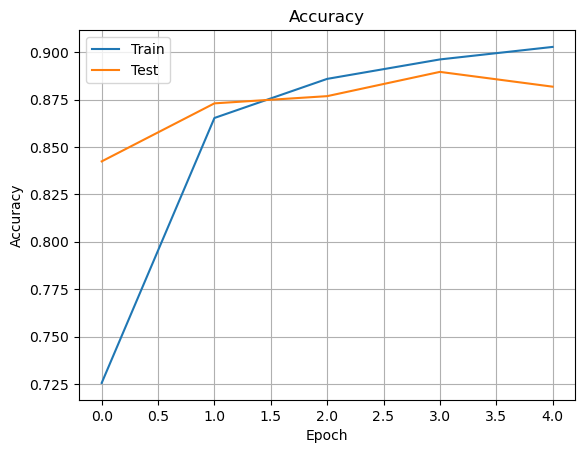

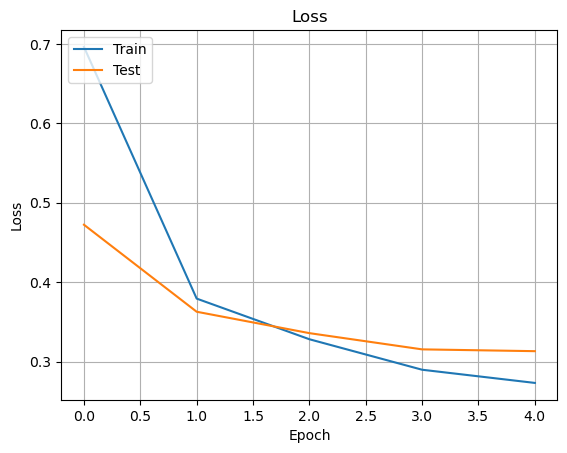

In [9]:
""" Visualize results, Accuracy and Loss Graphs"""
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.show()

In [10]:
"""Make decisions for 10 first examples"""
predicted = GoogLeNet.predict(X_test,batch_size=batch_size, verbose=1)
predicted = np.argmax(predicted, axis = 1)[:10]
label = y_test[:10]
print("Predicted label: ", *predicted)
print("True label     : ", *label)

79/79 [==============================] - 1s 6ms/step
Predicted label:  9 2 1 1 6 1 4 6 5 7
True label     :  9 2 1 1 6 1 4 6 5 7


---
## 2. PyTorch
### 2.1 Data Processing

In [11]:
""" Import necessary libraries """
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from numba import cuda
cuda.select_device(1)

<weakproxy at 0x787c52b62a70 to Device at 0x787c52b5e0b0>

In [12]:
"""Device configuration"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

""" Function support load data"""
def data_loader(data_dir, batch_size, random_seed=79, valid_size=0.1, shuffle=True, test=False):
    normalize = transforms.Normalize(mean=[0.4914], std=[0.2023],)

    """Define transforms"""
    transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),normalize,])

    if test:
        dataset = datasets.FashionMNIST(root=data_dir, train=False, download=True, transform=transform,)
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
        return data_loader

    """Load the dataset"""
    train_dataset = datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=transform,)
    valid_dataset = datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=transform,)

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(79)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler)
    return (train_loader, valid_loader)


"""FashionMNIST dataset """
train_loader, valid_loader = data_loader(data_dir='./data', batch_size=64)
test_loader = data_loader(data_dir='./data', batch_size=64, test=True)

cuda


100%|██████████| 26421880/26421880 [00:01<00:00, 15145181.44it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 273264.01it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5112634.25it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12009052.83it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



### 2.2 Architecture

In [13]:
class ConvBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class Inception(nn.Module):
    
    def __init__(self, input_channels, p1, p2, p3, p4):
        super(Inception, self).__init__()
        
        self.p1 = ConvBlock(input_channels, p1, kernel_size=1)
        
        self.p2_1 = ConvBlock(input_channels, p2[0], kernel_size=1)  
        self.p2_2 = ConvBlock(p2[0], p2[1], kernel_size=3, padding=1)
        
        self.p3_1 = ConvBlock(input_channels, p3[0], kernel_size=1)
        self.p3_2 = ConvBlock(p3[0], p3[1], kernel_size=5, padding=2)
        
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = ConvBlock(input_channels, p4, kernel_size=1)
         
    def forward(self, x):
        out_1 = self.p1(x)
        
        out_2 = self.p2_1(x)
        out_2 = self.p2_2(out_2)
        
        out_3 = self.p3_1(x)
        out_3 = self.p3_2(out_3)
        
        out_4 = self.p4_1(x)
        out_4 = self.p4_2(out_4)
        
        out = torch.cat([out_1, out_2, out_3, out_4], 1)
        return out

class Auxiliary(nn.Module):
    
    def __init__(self, in_channels, num_classes):
        super(Auxiliary, self).__init__()
        self.avgpool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv1x1 = ConvBlock(in_channels, 128, kernel_size=1)
        
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        
        self.dropout = nn.Dropout(0.7)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.avgpool(x)
        out = self.conv1x1(out)
        out = out.reshape(out.shape[0], -1)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [14]:
""" GoogLeNet architecture"""
class GoogLeNet(nn.Module):
    
    def __init__(self, in_channels=1, use_auxiliary=True, num_classes=1000):
        super(GoogLeNet, self).__init__()
        
        self.conv1 = ConvBlock(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.conv2 = ConvBlock(64, 192, kernel_size=3, stride=1, padding=1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        
        self.dropout = nn.Dropout(0.4)
        self.linear = nn.Linear(1024, num_classes)
        
        self.use_auxiliary = use_auxiliary
        if use_auxiliary:
            self.auxiliary1 = Auxiliary(512, num_classes)
            self.auxiliary2 = Auxiliary(528, num_classes)
        
        self.inception1 = Inception(192, 64, (96, 128), (16, 32), 32)
        self.inception2 = Inception(256, 128, (128, 192), (32, 96), 64)
        self.inception3 = Inception(480, 192, (96, 208), (16, 48), 64)
        self.inception4 = Inception(512, 160, (112, 224), (24, 64), 64)
        self.inception5 = Inception(512, 128, (128, 256), (24, 64), 64)
        self.inception6 = Inception(512, 112, (144, 288), (32, 64), 64)
        self.inception7 = Inception(528, 256, (160, 320), (32, 128), 128)
        self.inception8 = Inception(832, 256, (160, 320), (32, 128), 128)
        self.inception9 = Inception(832, 384, (192, 384), (48, 128), 128)

    def forward(self, x):
        out_2 = None
        out_3 = None
        
        out_1 = self.conv1(x)
        out_1 = self.maxpool(out_1)
        out_1 = self.conv2(out_1)
        out_1 = self.maxpool(out_1)
        
        out_1 = self.inception1(out_1)
        out_1 = self.inception2(out_1)
        out_1 = self.maxpool(out_1)
        
        out_1 = self.inception3(out_1)
        if self.use_auxiliary:
            out_2 = self.auxiliary1(out_1)
        
        out_1 = self.inception4(out_1)
        out_1 = self.inception5(out_1)
        out_1 = self.inception6(out_1)
        if self.use_auxiliary:
            out_3 = self.auxiliary2(out_1)
        
        out_1 = self.inception7(out_1)
        out_1 = self.maxpool(out_1)
        
        out_1 = self.inception8(out_1)
        out_1 = self.inception9(out_1)
        out_1 = self.avgpool(out_1)
        out_1 = out_1.reshape(out_1.shape[0], -1)
        out_1 = self.dropout(out_1)
        
        out_1 = self.linear(out_1)
        
        return out_1, out_2, out_3

model = GoogLeNet().to(device)
print(model)

GoogLeNet(
  (conv1): ConvBlock(
    (conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2): ConvBlock(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (avgpool): AvgPool2d(kernel_size=7, stride=1, padding=0)
  (dropout): Dropout(p=0.4, inplace=False)
  (linear): Linear(in_features=1024, out_features=1000, bias=True)
  (auxiliary1): Auxiliary(
    (avgpool): AvgPool2d(kernel_size=5, stride=3, padding=0)
    (conv1x1): ConvBlock(
      (conv): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (

In [15]:
""" Hyperparameter values"""
num_epochs = 5
batch_size = 4
learning_rate = 0.005

"""Loss and optimizer"""
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

### 2.3 Training

In [16]:
"""Train the model"""
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs, aux1, aux2 = model(images)
        loss = criterion(outputs, labels) + 0.3 * criterion(aux1, labels) + 0.3 * criterion(aux2, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs, _, _ = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total)) 

Epoch [1/5], Step [844/844], Loss: 0.2890
Accuracy of the network on the 5000 validation images: 88.43333333333334 %
Epoch [2/5], Step [844/844], Loss: 0.4990
Accuracy of the network on the 5000 validation images: 90.33333333333333 %
Epoch [3/5], Step [844/844], Loss: 0.3535
Accuracy of the network on the 5000 validation images: 92.3 %
Epoch [4/5], Step [844/844], Loss: 0.4051
Accuracy of the network on the 5000 validation images: 92.0 %
Epoch [5/5], Step [844/844], Loss: 0.2768
Accuracy of the network on the 5000 validation images: 92.43333333333334 %
